In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

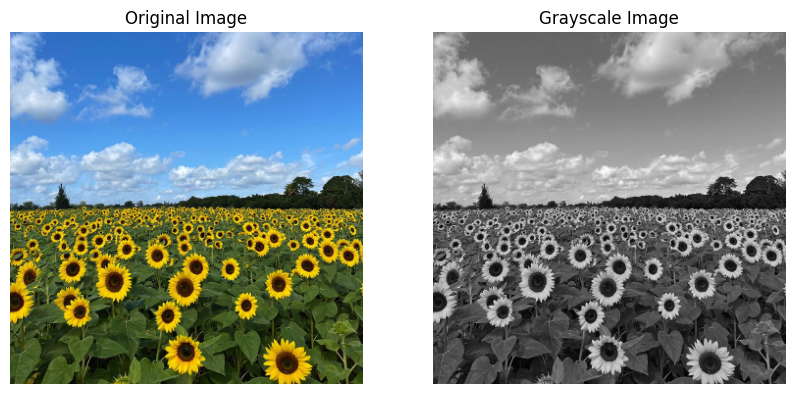

In [2]:
img=cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_rgb=cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()


In [4]:
def laplacian_of_gaussian(image, sigma):
    img_float = image.astype(np.float32)
    gaussian = cv.GaussianBlur(img_float, (0, 0), sigma)
    laplacian = cv.Laplacian(gaussian, cv.CV_32F,ksize=3)
    
    # Normalize by sigma^2 to make scale-invariant
    log_response = laplacian * (sigma ** 2)
    
    return log_response


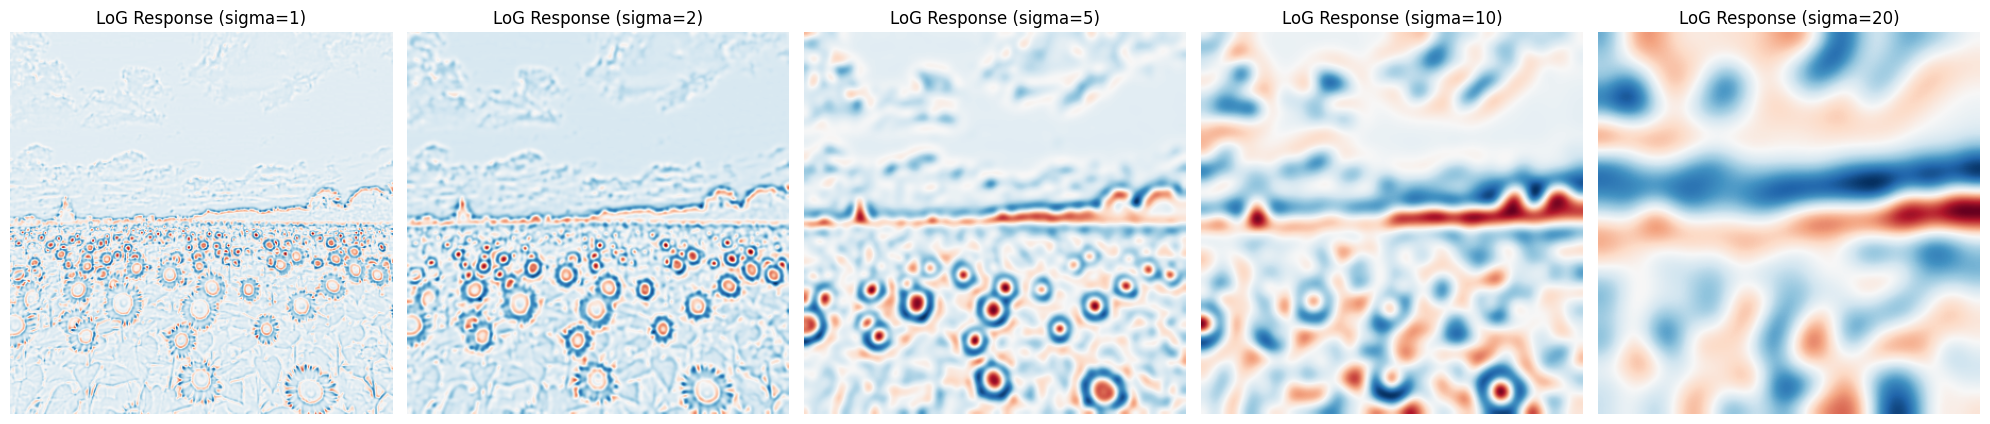

In [6]:
sigma_test=[1,2,5,10,20]
fig,axis=plt.subplots(1,5,figsize=(20,10))
for i,sigma in enumerate(sigma_test):
    log_response=laplacian_of_gaussian(gray,sigma)
    axis[i].imshow(log_response,cmap='RdBu_r')
    axis[i].set_title(f'LoG Response (sigma={sigma})')
    axis[i].axis('off')
plt.tight_layout()
plt.show()

In [12]:
def blob_detection_log(image):
    sigma_min = 1
    sigma_max = 30
    num_scales = 10
    threshold = 0.2

    sigmas=np.logspace(np.log10(sigma_min), np.log10(sigma_max), num_scales)
    print("Scales (sigmas):", sigmas)
    log_responses=[]

    for i, sigma in enumerate(sigmas):
        log_response = laplacian_of_gaussian(image, sigma)
        log_responses.append(log_response)
    log_response_stack = np.stack(log_responses, axis=2)
    return log_response_stack, sigmas
        

In [13]:
def find_scale_space_extrema(log_response_stack, sigmas, threshold=99):
    from scipy.ndimage import maximum_filter

    log_stack_neg=-log_response_stack
    threshold=np.percentile(log_stack_neg, 99)
    print("Threshold:", threshold)

    neighborhood_size = 3
    local_max = maximum_filter(log_stack_neg, size=neighborhood_size)==log_stack_neg
    detected_peaks = (log_stack_neg > threshold) & local_max
    y, x, scale_indices = np.where(detected_peaks)

    blobs = []
    for yi, xi, si in zip(y, x, scale_indices):
        sigma = sigmas[si]
        response = log_stack_neg[yi, xi, si]
        radius = np.sqrt(2) * sigma
        blobs.append((yi, xi, sigma, response, radius))
    
    blobs.sort(key=lambda b: b[3], reverse=True)
    print(f"Detected {len(blobs)} blobs")
    return blobs



In [16]:
def non_maximum_suppression(blobs, overlap_threshold=0.5):
    if len(blobs) == 0:
        return []

    blobs_arr= np.array(blobs)
    keep = []

    for i in range(len(blobs)):
        current_blob = blobs[i]
        y,x,sigma,response,radius = current_blob

        overlap=False
        for j in keep:
            yj,xj,sigmaj,responsej,radiusj = blobs[j]
            distance = np.sqrt((x - xj) ** 2 + (y - yj) ** 2)
            overlap_ratio=(radius + radiusj - distance) / min(radius, radiusj)
            if overlap_ratio> overlap_threshold:
                overlap = True
                break
        if not overlap:
            keep.append(i)
        
        fillter_blobs = [blobs[i] for i in keep]
    return fillter_blobs


In [17]:
log_response_stack, sigmas = blob_detection_log(gray)
blobs = find_scale_space_extrema(log_response_stack, sigmas, threshold=99)
#print("Top 5 blobs (y, x, sigma, response, radius):", blobs[:5])
filtered_blobs = non_maximum_suppression(blobs, overlap_threshold=0.5)

if filtered_blobs:
    radii = [b[4] for b in filtered_blobs]
    responses= [b[3] for b in filtered_blobs]

    print(f"Radius range: {min(radii):.2f} to {max(radii):.2f} pixels")
    print(f"Mean radius: {np.mean(radii):.2f} pixels")
    print(f"Response range: {min(responses):.2f} to {max(responses):.2f}")
     # Draw all detected blobs in green with thin lines


Scales (sigmas): [ 1.          1.4592328   2.12936037  3.10723251  4.5341756   6.61641777
  9.65489385 14.08873781 20.55874836 30.        ]
Threshold: 155.76433390779076
Detected 369 blobs
Radius range: 1.41 to 13.65 pixels
Mean radius: 2.86 pixels
Response range: 155.93 to 291.75


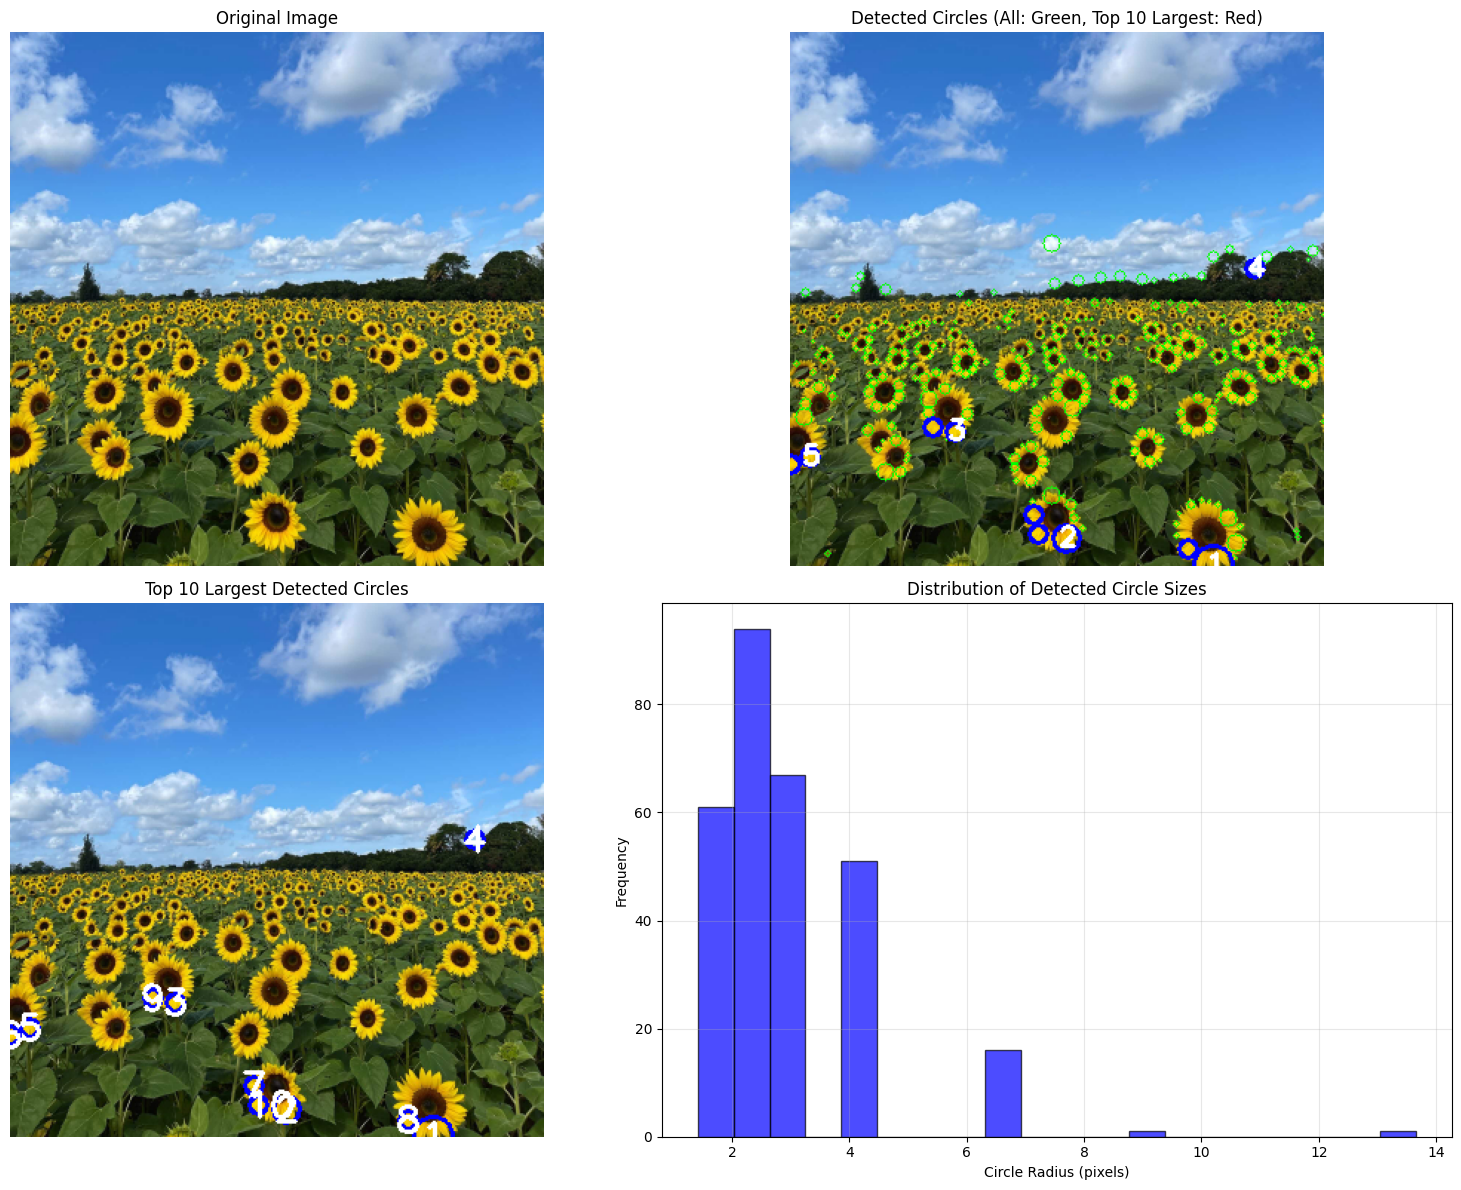

\n============================================================
DETAILED ANALYSIS OF DETECTED CIRCLES
\nTotal circles detected: 291
Sigma range used: 1.00 to 30.00
Number of sigma values tested: 10
\nTop 10 Largest Circles:
Rank Center (x,y) Sigma    Radius   Response  
--------------------------------------------------
1    (285,359)       9.65   13.65   185.35
2    (186,341)       6.62   9.36   256.84
3    (111,269)       4.53   6.41   291.75
4    (313,159)       4.53   6.41   283.00
5    (13,286)       4.53   6.41   272.08
6    (0,291)       4.53   6.41   267.57
7    (164,325)       4.53   6.41   255.93
8    (268,348)       4.53   6.41   255.56
9    (96,266)       4.53   6.41   249.47
10   (167,338)       4.53   6.41   247.06
\nStatistical Summary:
Sigma values - Min: 1.00, Max: 9.65, Mean: 2.02
Circle radii - Min: 1.41, Max: 13.65, Mean: 2.86
Largest circle radius: 13.65 pixels (sigma = 9.65)
\nMost effective sigma values:
σ = 1.46: 94 detections
σ = 2.13: 67 detections
σ = 1.00: 61

In [25]:
def draw_detected_circles(image, blobs, num_largest=5):
    result_image = image.copy()
    
    
    blobs_by_radius = sorted(blobs, key=lambda b: b[4], reverse=True)
   
    for y, x, sigma, response, radius in blobs:
        cv.circle(result_image, (int(x), int(y)), int(radius), (0, 255, 0), 1)
 
    largest_blobs = blobs_by_radius[:num_largest]
    for i, (y, x, sigma, response, radius) in enumerate(largest_blobs):
        cv.circle(result_image, (int(x), int(y)), int(radius), (0, 0, 255), 2)
        # Add text label for the largest circles
        if i < 5:  # Label only top 5
            cv.putText(result_image, f'{i+1}', (int(x-5), int(y+5)), 
                      cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return result_image, largest_blobs

# Draw the detected circles
result_img, largest_circles = draw_detected_circles(img_rgb, filtered_blobs, num_largest=10)

# Display results
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(result_img)
plt.title(f'Detected Circles (All: Green, Top 10 Largest: Red)')
plt.axis('off')

# Show just the largest circles
result_largest = img_rgb.copy()
for i, (y, x, sigma, response, radius) in enumerate(largest_circles):
    cv.circle(result_largest, (int(x), int(y)), int(radius), (0, 0, 255), 2)
    cv.putText(result_largest, f'{i+1}', (int(x-8), int(y+8)), 
              cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

plt.subplot(2, 2, 3)
plt.imshow(result_largest)
plt.title('Top 10 Largest Detected Circles')
plt.axis('off')

# Create a visualization of blob sizes
radii = [b[4] for b in filtered_blobs]
plt.subplot(2, 2, 4)
plt.hist(radii, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Circle Radius (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Detected Circle Sizes')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report detailed information about the largest circles
print("\\n" + "="*60)
print("DETAILED ANALYSIS OF DETECTED CIRCLES")
print("="*60)

print(f"\\nTotal circles detected: {len(filtered_blobs)}")
print(f"Sigma range used: {sigmas[0]:.2f} to {sigmas[-1]:.2f}")
print(f"Number of sigma values tested: {len(sigmas)}")

print(f"\\nTop 10 Largest Circles:")
print(f"{'Rank':<4} {'Center (x,y)':<12} {'Sigma':<8} {'Radius':<8} {'Response':<10}")
print("-" * 50)

for i, (y, x, sigma, response, radius) in enumerate(largest_circles):
    print(f"{i+1:<4} ({x:.0f},{y:.0f}){'':<6} {sigma:.2f}{'':<2} {radius:.2f}{'':<2} {response:.2f}")

# Additional statistics
all_radii = [b[4] for b in filtered_blobs]
all_sigmas = [b[2] for b in filtered_blobs]

print(f"\\nStatistical Summary:")
print(f"Sigma values - Min: {min(all_sigmas):.2f}, Max: {max(all_sigmas):.2f}, Mean: {np.mean(all_sigmas):.2f}")
print(f"Circle radii - Min: {min(all_radii):.2f}, Max: {max(all_radii):.2f}, Mean: {np.mean(all_radii):.2f}")
print(f"Largest circle radius: {max(all_radii):.2f} pixels (sigma = {max(all_sigmas):.2f})")

# Show which sigma values were most effective
sigma_counts = {}
for _, _, sigma, _,_ in filtered_blobs:
    # Find closest sigma value from our test range
    closest_sigma_idx = np.argmin(np.abs(sigmas - sigma))
    closest_sigma = sigmas[closest_sigma_idx]
    sigma_counts[closest_sigma] = sigma_counts.get(closest_sigma, 0) + 1

print(f"\\nMost effective sigma values:")
for sigma, count in sorted(sigma_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"σ = {sigma:.2f}: {count} detections")